# Age, Gender & Expression Recognizer

## 1. Setup and Preparation

### 1.1 Import Libraries and Setting Up Device-agnostic code

In [1]:
import torch
import pandas as pd

from torch import nn
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms

torch.__version__

'2.4.1+cu121'

In [2]:
# Setting device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 1.2 Configuration

In [3]:
data_path = Path('/kaggle/input/')

AGE_FILE_PATH = data_path / 'facial-age'
EMOTION_FILE_PATH = data_path / 'facial-emotion-expressions'
GENDER_FILE_PATH = data_path / 'gender-recognizer'

In [4]:
AGE_FILE_PATH, EMOTION_FILE_PATH, GENDER_FILE_PATH

(PosixPath('/kaggle/input/facial-age'),
 PosixPath('/kaggle/input/facial-emotion-expressions'),
 PosixPath('/kaggle/input/gender-recognizer'))

### 1.3 Load Datasets

In [5]:
import os

def walk_throuhg_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [6]:
walk_throuhg_dir(AGE_FILE_PATH)

There are 1 directories and 0 images in /kaggle/input/facial-age
There are 100 directories and 0 images in /kaggle/input/facial-age/face_age
There are 0 directories and 60 images in /kaggle/input/facial-age/face_age/057
There are 0 directories and 22 images in /kaggle/input/facial-age/face_age/086
There are 0 directories and 50 images in /kaggle/input/facial-age/face_age/061
There are 0 directories and 64 images in /kaggle/input/facial-age/face_age/048
There are 0 directories and 133 images in /kaggle/input/facial-age/face_age/053
There are 0 directories and 62 images in /kaggle/input/facial-age/face_age/051
There are 0 directories and 3 images in /kaggle/input/facial-age/face_age/095
There are 0 directories and 181 images in /kaggle/input/facial-age/face_age/018
There are 0 directories and 27 images in /kaggle/input/facial-age/face_age/044
There are 0 directories and 212 images in /kaggle/input/facial-age/face_age/016
There are 0 directories and 126 images in /kaggle/input/facial-age/

In [7]:
walk_throuhg_dir(EMOTION_FILE_PATH)

There are 1 directories and 0 images in /kaggle/input/facial-emotion-expressions
There are 3 directories and 0 images in /kaggle/input/facial-emotion-expressions/images
There are 7 directories and 0 images in /kaggle/input/facial-emotion-expressions/images/validation
There are 0 directories and 797 images in /kaggle/input/facial-emotion-expressions/images/validation/surprise
There are 0 directories and 1018 images in /kaggle/input/facial-emotion-expressions/images/validation/fear
There are 0 directories and 960 images in /kaggle/input/facial-emotion-expressions/images/validation/angry
There are 0 directories and 1216 images in /kaggle/input/facial-emotion-expressions/images/validation/neutral
There are 0 directories and 1139 images in /kaggle/input/facial-emotion-expressions/images/validation/sad
There are 0 directories and 111 images in /kaggle/input/facial-emotion-expressions/images/validation/disgust
There are 0 directories and 1825 images in /kaggle/input/facial-emotion-expressions

In [8]:
walk_throuhg_dir(GENDER_FILE_PATH)

There are 1 directories and 0 images in /kaggle/input/gender-recognizer
There are 2 directories and 0 images in /kaggle/input/gender-recognizer/dataset
There are 0 directories and 646 images in /kaggle/input/gender-recognizer/dataset/MEN
There are 1 directories and 646 images in /kaggle/input/gender-recognizer/dataset/WOMAN
There are 0 directories and 646 images in /kaggle/input/gender-recognizer/dataset/WOMAN/MEN


## 2. Data Preprocessing

### Age Dataset

In [9]:
# List all file paths in the directory
paths = [path for path in AGE_FILE_PATH.rglob('*/*.png')]

# Create the DataFrame with relevant columns
age_df = pd.DataFrame({
    'file_path': paths,
    'file_name': [path.name for path in paths],  # Extract file name
    'label': [path.parts[-2] for path in paths]  # Extract folder name as label
})
age_df.head()

,file_path,file_name,label
0,/kaggle/input/facial-age/face_age/057/6802.png,6802.png,057
1,/kaggle/input/facial-age/face_age/057/3702.png,3702.png,057
2,/kaggle/input/facial-age/face_age/057/8810.png,8810.png,057
3,/kaggle/input/facial-age/face_age/057/6759.png,6759.png,057
4,/kaggle/input/facial-age/face_age/057/1846.png,1846.png,057


In [10]:
age_df.shape

(19556, 3)

In [11]:
# Droping duplicated values
print(age_df.duplicated(['file_name', 'label']).sum())
age_df.drop_duplicates(['file_name', 'label'], inplace=True)

9778


In [12]:
age_df.shape

(9778, 3)

In [13]:
# Count the number of images for each label
age_df['label'].value_counts()

label
001    1112
002     475
003     284
026     279
004     260
       ... 
099       2
110       2
100       2
101       1
091       1
Name: count, Length: 99, dtype: int64

In [14]:
# Define bins and labels
age_bins = [0, 3, 12, 19, 28, 55, 70]
age_labels = ['Baby', 'Child', 'Teen', 'Young Adult', 'Adult', 'Elderly']

# Assign age categories based on bins
age_df['age_category'] = pd.cut(age_df['label'].astype(int), bins=age_bins, labels=age_labels, right=False)
age_df.head()

,file_path,file_name,label,age_category
0,/kaggle/input/facial-age/face_age/057/6802.png,6802.png,057,Elderly
1,/kaggle/input/facial-age/face_age/057/3702.png,3702.png,057,Elderly
2,/kaggle/input/facial-age/face_age/057/8810.png,8810.png,057,Elderly
3,/kaggle/input/facial-age/face_age/057/6759.png,6759.png,057,Elderly
4,/kaggle/input/facial-age/face_age/057/1846.png,1846.png,057,Elderly


In [15]:
age_df['age_category'].value_counts()

age_category
Adult          2543
Baby           1587
Child          1562
Young Adult    1280
Elderly        1055
Teen            957
Name: count, dtype: int64

In [16]:
age_df.drop('label', axis=1, inplace=True)
print(age_df.shape)
age_df.head()

(9778, 3)


,file_path,file_name,age_category
0,/kaggle/input/facial-age/face_age/057/6802.png,6802.png,Elderly
1,/kaggle/input/facial-age/face_age/057/3702.png,3702.png,Elderly
2,/kaggle/input/facial-age/face_age/057/8810.png,8810.png,Elderly
3,/kaggle/input/facial-age/face_age/057/6759.png,6759.png,Elderly
4,/kaggle/input/facial-age/face_age/057/1846.png,1846.png,Elderly


In [17]:
train_age_data, test_age_data = train_test_split(age_df, shuffle=True, test_size=0.1)
train_age_data, val_age_data = train_test_split(train_age_data, shuffle=True, test_size=0.2)
train_age_data.head()

,file_path,file_name,age_category
4177,/kaggle/input/facial-age/face_age/034/1091.png,1091.png,Adult
9711,/kaggle/input/facial-age/face_age/085/4642.png,4642.png,NaN
4815,/kaggle/input/facial-age/face_age/023/8456.png,8456.png,Young Adult
8546,/kaggle/input/facial-age/face_age/037/3144.png,3144.png,Adult
1396,/kaggle/input/facial-age/face_age/025/6093.png,6093.png,Young Adult


In [18]:
test_age_data.head()

,file_path,file_name,age_category
1609,/kaggle/input/facial-age/face_age/001/9261.png,9261.png,Baby
1227,/kaggle/input/facial-age/face_age/029/8016.png,8016.png,Adult
4382,/kaggle/input/facial-age/face_age/060/4165.png,4165.png,Elderly
8972,/kaggle/input/facial-age/face_age/010/605.png,605.png,Child
8425,/kaggle/input/facial-age/face_age/024/5966.png,5966.png,Young Adult


In [19]:
val_age_data.head()

,file_path,file_name,age_category
8992,/kaggle/input/facial-age/face_age/010/2467.png,2467.png,Child
5977,/kaggle/input/facial-age/face_age/002/1845.png,1845.png,Baby
2613,/kaggle/input/facial-age/face_age/001/5596.png,5596.png,Baby
685,/kaggle/input/facial-age/face_age/016/5410.png,5410.png,Teen
9722,/kaggle/input/facial-age/face_age/085/4061.png,4061.png,NaN


In [20]:
train_age_data.shape, val_age_data.shape, test_age_data.shape

((7040, 3), (1760, 3), (978, 3))

In [21]:
age_idx = {label:i for i, label in enumerate(age_labels)}
age_idx

{'Baby': 0, 'Child': 1, 'Teen': 2, 'Young Adult': 3, 'Adult': 4, 'Elderly': 5}

### Data Transformation

In [22]:
# Define the transformation pipeline
train_transforms_trivial = transforms.Compose([
    transforms.Resize(size=(224, 224)),  # Resize to 224x224
    transforms.TrivialAugmentWide(num_magnitude_bins=31),  # Apply TrivialAugmentWide
    transforms.ToTensor()  # Convert to tensor
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),  # Resize to 224x224
    transforms.ToTensor()  # Convert to tensor
])

In [23]:
from tqdm import tqdm

def convert_image_into_tensor(file_path, transform):
    # Apply transformation to all images and store tensors
    image_tensors = []
    
    for file_path in tqdm(file_path, desc="Processing images"):
        # Open image, ensure RGB mode, and apply transformations
        image = Image.open(file_path).convert('RGB')
        tensor = transform(image)
        image_tensors.append(tensor)
    
    # Stack tensors into a single tensor for batch processing
    image_tensors = torch.stack(image_tensors)  # Shape: (N, 3, 64, 64)
    return image_tensors

train_image_tensors = convert_image_into_tensor(file_path=train_age_data['file_path'], transform=train_transforms_trivial)
print(f"Processed {len(train_image_tensors)} images with shape: {train_image_tensors.shape}")

Processing images: 100%|██████████| 7040/7040 [00:47<00:00, 147.14it/s]


Processed 7040 images with shape: torch.Size([7040, 3, 224, 224])


In [24]:
val_image_tensors = convert_image_into_tensor(file_path=val_age_data['file_path'], transform=train_transforms_trivial)
print(f"Processed {len(val_image_tensors)} images with shape: {val_image_tensors.shape}")

Processing images: 100%|██████████| 1760/1760 [00:11<00:00, 149.01it/s]


Processed 1760 images with shape: torch.Size([1760, 3, 224, 224])


In [25]:
test_image_tensors = convert_image_into_tensor(file_path=test_age_data['file_path'], transform=train_transforms_trivial)
print(f"Processed {len(test_image_tensors)} images with shape: {test_image_tensors.shape}")

Processing images: 100%|██████████| 978/978 [00:06<00:00, 148.98it/s]


Processed 978 images with shape: torch.Size([978, 3, 224, 224])


In [26]:
train_image_tensors[0].shape

torch.Size([3, 224, 224])

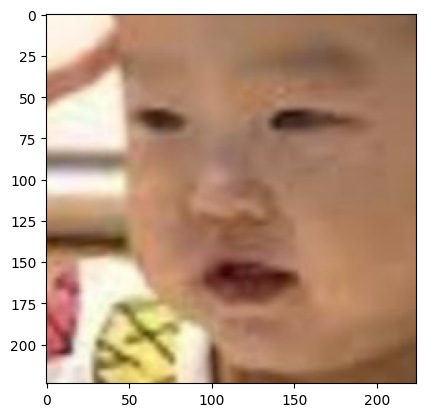

In [27]:
plt.imshow(train_image_tensors[150].permute(1, 2, 0))